In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors, colormaps
import scipy
import copy
from tqdm.notebook import tqdm
import numpy as np

In [3]:
def average_efficiency(emission_spectrum, qe_x, qe_y):
    eff = 0
    x_emission = emission_spectrum[:,0]
    y_emission = emission_spectrum[:,1]
    total_area = np.trapz(y_emission, x=x_emission)
    
    for i in range(emission_spectrum.shape[0]-1):
        area = np.trapz(y_emission[i:i+2], x=x_emission[i:i+2]) / total_area
        x = (x_emission[i] + x_emission[i+1])/2
        eff += area * np.interp(x, qe_x, qe_y)
        
    return eff

y11_spectrum = np.loadtxt("y11_emission.csv",delimiter=",")
b2_spectrum = np.loadtxt("b2_emission.csv",delimiter=",")
led_375_spectrum = np.loadtxt("led_375.txt",delimiter=",")
led_430_spectrum = np.loadtxt("led_430.txt",delimiter=",")

h13542_20_sensitivity = np.loadtxt("h13543_20_sensitivity.csv",delimiter=",")
hamamatsu_efficiency = np.loadtxt("sipm_efficiency.csv",delimiter=",")
fbk_efficiency = np.loadtxt("fbk_efficiency2.csv",delimiter=",")

x_pmt = h13542_20_sensitivity[:,0]
y_pmt = h13542_20_sensitivity[:,1]
qe_pmt =  124 * y_pmt / x_pmt

fibers_qe_pmt = average_efficiency(y11_spectrum, x_pmt, qe_pmt)
fibers_qe_hamamatsu = average_efficiency(y11_spectrum, hamamatsu_efficiency[:,0], hamamatsu_efficiency[:,1])
fibers_qe_fbk =  average_efficiency(y11_spectrum, fbk_efficiency[:,0], fbk_efficiency[:,1])
fibers_b2_qe_fbk =  average_efficiency(b2_spectrum, fbk_efficiency[:,0], fbk_efficiency[:,1])
fibers_b2_qe_hamamatsu =  average_efficiency(b2_spectrum, hamamatsu_efficiency[:,0], hamamatsu_efficiency[:,1])
fibers_b2_qe_pmt =  average_efficiency(b2_spectrum, x_pmt, qe_pmt)

In [4]:
with open("hamamatsu/sipm_single_photon_dig2-192.168.0.254-01.txt") as single_photon:
    lines = single_photon.readlines()

In [5]:
integral = []

total_time = []
total_voltage = []

for event in range(10300):
    # event = 2
    noheader = lines[event*(188+5):(event+1)*(188+5)][5:]
    numbers = []
    for l in noheader:
        numbers.append([float(i) for i in l.split("\t")[:3]])

    numbers = np.array(numbers)
    time = numbers[:,0]*0.008
    total_time.append(time)
    
    voltage = numbers[:,2]
    total_voltage.append(voltage)
    # ax.plot(time, voltage, alpha=0.05, c='gray')
    integral_window = (time>0.57)&(time<1.35)

    # crossing_index = np.argwhere(voltage[integral_window]>threshold)[0][0]
    # if time[crossing_index] < 0.65:
    this_integral = np.trapz(voltage[integral_window]+18.73, x=time[integral_window])
    integral.append(this_integral)
    # if event == 0:
    #     ax.plot(numbers[:,0]*0.008, numbers[:,1], c='r',zorder=np.inf)

In [6]:
def five_norm(x, *args):
    m1, m2, m3, m4, m5, s1, s2, s3, s4, s5, k1, k2, k3, k4, k5 = args
    ret = k1*scipy.stats.norm.pdf(x, loc=m1 ,scale=s1)
    ret += k2*scipy.stats.norm.pdf(x, loc=m2 ,scale=s2)
    ret += k3*scipy.stats.norm.pdf(x, loc=m3 ,scale=s3)
    ret += k4*scipy.stats.norm.pdf(x, loc=m4 ,scale=s4)
    ret += k5*scipy.stats.norm.pdf(x, loc=m5 ,scale=s5)
    return ret

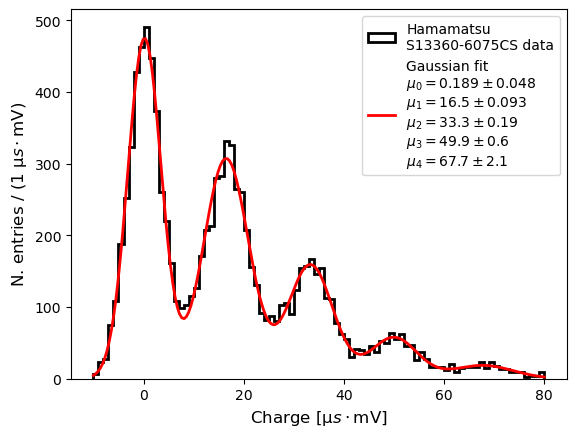

In [7]:
fig, ax = plt.subplots(1,1)
n, bins, patches =ax.hist(integral, bins=90, range=(-10, 80), histtype='step', lw=2, color='k', label='Hamamatsu\nS13360-6075CS data')

bin_centers = (bins[:-1] + bins[1:]) / 2
mus = [0, 15, 32, 48]
x = np.linspace(-10,80,200)
    
params = [0, 18, 38, 50, 70, 5, 5, 5, 7, 10, 1000, 1000, 1000, 400, 200]
    
p, pcov = scipy.optimize.curve_fit(five_norm, bin_centers, n, p0=params)
err = np.sqrt(np.diag(pcov))
ax.plot(x, five_norm(x,*p), c='r', label=rf'''Gaussian fit
$\mu_0={p[0]:.3g}\pm{err[0]:.2g}$
$\mu_1={p[1]:.3g}\pm{err[1]:.2g}$
$\mu_2={p[2]:.3g}\pm{err[2]:.2g}$
$\mu_3={p[3]:.3g}\pm{err[3]:.2g}$
$\mu_4={p[4]:.3g}\pm{err[4]:.2g}$''')
ax.legend()
ax.set_xlabel("Charge [$\mathrm{\mu}s\cdot$mV]", size='larger')
ax.set_ylabel("N. entries / (1 $\mathrm{\mu}s\cdot$mV)", size='larger')
fig.savefig("sipm_spectrum.pdf")

# ax.set_yscale("log")
# ax.set_ylim(1, 1e3)

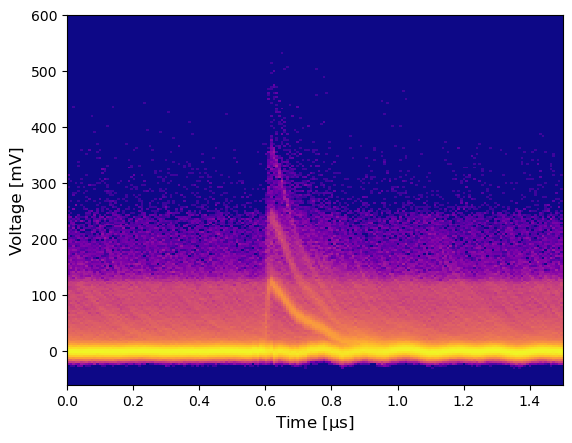

In [8]:
fig, ax = plt.subplots(1,1)
my_cmap = copy.copy(colormaps['plasma']) # copy the default cmap
my_cmap.set_bad(my_cmap.colors[0])

_=ax.hist2d(np.hstack(total_time), np.hstack(total_voltage)+18, bins=188, rasterized=True,
            range=((0,1.5), (-60,600)), cmap=my_cmap, norm=colors.LogNorm())
ax.set_xlabel(r"Time [$\mathrm{\mu}$s]", size='larger')
ax.set_ylabel("Voltage [mV]", size='larger')
fig.savefig("waveforms.pdf")

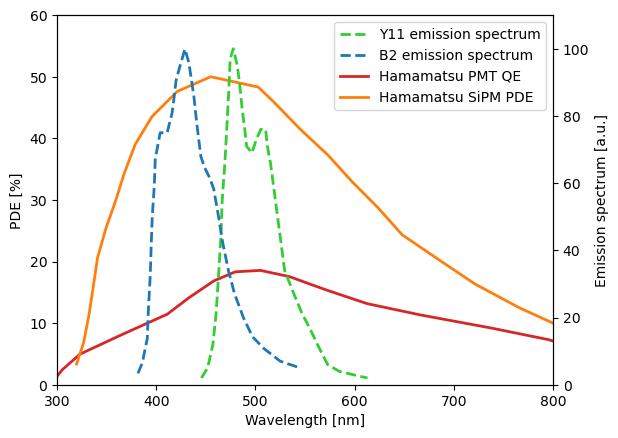

In [30]:
fig, ax = plt.subplots(1,1)

p1 = ax.plot(x_pmt, qe_pmt, c='tab:red', label="Hamamatsu PMT QE")
p2 = ax.plot(hamamatsu_efficiency[:,0], hamamatsu_efficiency[:,1], c='tab:orange', label="Hamamatsu SiPM PDE")
# p3 = ax.plot(fbk_efficiency[:,0], fbk_efficiency[:,1], c='tab:brown', label="FBK SiPM PDE")
ax.set_xlim(300,800)
ax.set_ylim(0, 60)
ax2=ax.twinx()

p4 = ax2.plot(y11_spectrum[:,0], y11_spectrum[:,1]*100,  label="Y11 emission spectrum", c='limegreen', ls='--')
p5 = ax2.plot(b2_spectrum[:,0], b2_spectrum[:,1]*100,  label="B2 emission spectrum", c='tab:blue', ls='--')

lns = p4+p5+p1+p2

labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax2.set_ylim(0,110)
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("PDE [%]")
ax2.set_ylabel("Emission spectrum [a.u.]")
fig.savefig("pde.pdf", transparent=True)

In [10]:
calib_qe_pmt = average_efficiency(led_430_spectrum, x_pmt, qe_pmt)
calib_qe_pmt_blue = average_efficiency(led_375_spectrum, x_pmt, qe_pmt)

calib_qe_hamamatsu = average_efficiency(led_430_spectrum, hamamatsu_efficiency[:,0], hamamatsu_efficiency[:,1])
calib_qe_hamamatsu_blue = average_efficiency(led_375_spectrum, hamamatsu_efficiency[:,0], hamamatsu_efficiency[:,1])

calib_qe_fbk = average_efficiency(led_430_spectrum, fbk_efficiency[:,0], fbk_efficiency[:,1])
calib_qe_fbk_blue = average_efficiency(led_375_spectrum, fbk_efficiency[:,0], fbk_efficiency[:,1])

In [31]:
n_fibers = 7

pmt_area = 18 * 18 # mm

calibration_run_pmt = "pmt_eff_y11/calib_dig2-192.168.0.254-09.txt"
measurement_run_pmt = "pmt_eff_y11/fiber_dig2-192.168.0.254-10.txt"
pmt_led = np.loadtxt(calibration_run_pmt, delimiter="\t",usecols=(2)).reshape(-1, 252)
pmt_control_led = np.loadtxt(calibration_run_pmt, delimiter="\t",usecols=(3)).reshape(-1, 252)

pmt_fibers = np.loadtxt(measurement_run_pmt, delimiter="\t",usecols=(2)).reshape(-1, 252)
pmt_control_fibers = np.loadtxt(measurement_run_pmt, delimiter="\t",usecols=(3)).reshape(-1, 252)

pmt_calibration_signal = np.average(np.trapz(pmt_led) / np.trapz(pmt_control_led))
pmt_fiber_signal = np.average(np.trapz(pmt_fibers) / np.trapz(pmt_control_fibers))

eff_fibers_pmt = pmt_fiber_signal / (n_fibers * 36) / (pmt_calibration_signal / calib_qe_pmt / pmt_area)
print(f"PMT Y11 eff {eff_fibers_pmt:g}")

PMT Y11 eff 2.09634


In [33]:
calibration_run_pmt_b2 = "pmt_eff_b2/led_dig2-192.168.0.254-12.txt"
measurement_run_pmt_b2 = "pmt_eff_b2/fibers_dig2-192.168.0.254-15.txt"
pmt_led_b2 = np.loadtxt(calibration_run_pmt_b2, delimiter="\t",usecols=(2)).reshape(-1, 252)
pmt_control_led_b2 = np.loadtxt(calibration_run_pmt_b2, delimiter="\t",usecols=(3)).reshape(-1, 252)

pmt_fibers_b2 = np.loadtxt(measurement_run_pmt_b2, delimiter="\t",usecols=(2)).reshape(-1, 252)
pmt_control_fibers_b2 = np.loadtxt(measurement_run_pmt_b2, delimiter="\t",usecols=(3)).reshape(-1, 252)

pmt_calibration_signal_b2 = np.average(np.trapz(pmt_led_b2) / np.trapz(pmt_control_led_b2))
pmt_fiber_signal_b2 = np.average(np.trapz(pmt_fibers_b2) / np.trapz(pmt_control_fibers_b2))
eff_fibers_pmt_b2 = pmt_fiber_signal_b2 / (n_fibers * 36) / (pmt_calibration_signal_b2 / calib_qe_pmt_blue / pmt_area)
print(f"PMT B2 eff {eff_fibers_pmt_b2:g}")

PMT B2 eff 1.3488


In [13]:
measurement_run_sipm = "fbk_eff_y11/fibers_dig2-192.168.0.155-27.txt"
calibration_run_sipm = "fbk_eff_y11/led_dig2-192.168.0.155-25.txt"
fbk_led = np.loadtxt(calibration_run_sipm, delimiter="\t",usecols=(3)).reshape(-1, 312)
fbk_control_led = np.loadtxt(calibration_run_sipm, delimiter="\t",usecols=(1)).reshape(-1, 312)
fbk_fibers = np.loadtxt(measurement_run_sipm, delimiter="\t",usecols=(3)).reshape(-1, 312)
fbk_control_fibers = np.loadtxt(measurement_run_sipm, delimiter="\t",usecols=(1)).reshape(-1, 312)

In [14]:
fbk_fiber_signal = np.average(np.trapz(fbk_fibers)/np.trapz(fbk_control_fibers))
fbk_calibration_signal = np.average(np.trapz(fbk_led)/np.trapz(fbk_control_led)) 

In [15]:
sipm_area = 7.9 * 11.7 # mm
n_fibers = 7
eff_fibers_fbk_y11 = fbk_fiber_signal / (n_fibers * 36) / (fbk_calibration_signal / (calib_qe_fbk * 0.75) / sipm_area)
print(f"FBK SiPM eff {eff_fibers_fbk_y11:g}")

FBK SiPM eff 3.07698


In [16]:
calibration_run_sipm = "sipm_no_fibers_dig2-192.168.0.254-20.txt"
measurement_run_sipm = "sipm_fibers_dig2-192.168.0.254-17.txt"

measurement_run_sipm = "fbk_eff_b2/fibers_dig2-192.168.0.155-09.txt"
calibration_run_sipm = "fbk_eff_b2/led_dig2-192.168.0.155-10.txt"
fbk_led = np.loadtxt(calibration_run_sipm, delimiter="\t",usecols=(3)).reshape(-1, 312)
fbk_control_led = np.loadtxt(calibration_run_sipm, delimiter="\t",usecols=(1)).reshape(-1, 312)
fbk_fibers = np.loadtxt(measurement_run_sipm, delimiter="\t",usecols=(3)).reshape(-1, 312)
fbk_control_fibers = np.loadtxt(measurement_run_sipm, delimiter="\t",usecols=(1)).reshape(-1, 312)

In [17]:
fbk_fiber_signal = np.average(np.trapz(fbk_fibers)/np.trapz(fbk_control_fibers)) 
fbk_calibration_signal = np.average(np.trapz(fbk_led)/np.trapz(fbk_control_led)) 

In [18]:
eff_fibers_fbk_b2 = fbk_fiber_signal / (n_fibers * 36) / (fbk_calibration_signal / (calib_qe_fbk_blue * 0.75) / sipm_area)
print(f"FBK SiPM b2 eff {eff_fibers_fbk_b2:g}")

FBK SiPM b2 eff 4.00455


In [143]:
calibration_run_hamamatsu = "hamamatsu/sipm_hamamatsu_calib_dig2-192.168.0.254-04.txt"
measurement_run_hamamatsu = "hamamatsu/sipm_fibers_dig2-192.168.0.254-05.txt"

calibration_run_hamamatsu = "sipm_eff_y11/calib_dig2-192.168.0.254-10.txt"
measurement_run_hamamatsu = "sipm_eff_y11/fibers_dig2-192.168.0.254-11.txt"

hamamatsu_led = np.loadtxt(calibration_run_hamamatsu, delimiter="\t",usecols=(3)).reshape(-1, 500)
hamamatsu_control_led = np.loadtxt(calibration_run_hamamatsu, delimiter="\t",usecols=(2)).reshape(-1,500)
hamamatsu_fibers = np.loadtxt(measurement_run_hamamatsu, delimiter="\t",usecols=(3)).reshape(-1, 500)
hamamatsu_control_fibers = np.loadtxt(measurement_run_hamamatsu, delimiter="\t",usecols=(2)).reshape(-1, 500)

In [144]:
led_offset = np.mean(hamamatsu_led[:,:50])
fiber_offset = np.mean(hamamatsu_fibers[:,:50])
hamamatsu_fiber_signal = np.average(np.trapz(hamamatsu_fibers-fiber_offset))
hamamatsu_calibration_signal = np.average(np.trapz(hamamatsu_led-led_offset))

In [145]:
sipm_area = 6 * 6 # mm2
n_fibers = 7
eff_fibers_hamamatsu = hamamatsu_fiber_signal / (n_fibers * 36) / (hamamatsu_calibration_signal / calib_qe_hamamatsu / sipm_area) 
print(f"Hamamatsu SiPM eff {eff_fibers_hamamatsu:g}")

Hamamatsu SiPM eff 3.50606


In [22]:
calibration_run_hamamatsu = "sipm_eff_b2/led_dig2-192.168.0.254-03.txt"
measurement_run_hamamatsu = "sipm_eff_b2/fibers_dig2-192.168.0.254-07.txt"

hamamatsu_led = np.loadtxt(calibration_run_hamamatsu, delimiter="\t",usecols=(3)).reshape(-1, 1000)
hamamatsu_control_led = np.loadtxt(calibration_run_hamamatsu, delimiter="\t",usecols=(2)).reshape(-1, 1000)
hamamatsu_fibers = np.loadtxt(measurement_run_hamamatsu, delimiter="\t",usecols=(3)).reshape(-1, 1000)
hamamatsu_control_fibers = np.loadtxt(measurement_run_hamamatsu, delimiter="\t",usecols=(2)).reshape(-1, 1000)

In [23]:
led_offset = np.mean(hamamatsu_led[:,:50])
fiber_offset = np.mean(hamamatsu_fibers[:,:50])

In [24]:
hamamatsu_fiber_signal = np.average(np.trapz(hamamatsu_fibers-fiber_offset)/np.trapz(hamamatsu_control_fibers))
hamamatsu_calibration_signal = np.average(np.trapz(hamamatsu_led-led_offset)/np.trapz(hamamatsu_control_led))

In [25]:
eff_fibers_hamamatsu_b2 = hamamatsu_fiber_signal / (n_fibers * 36) / (hamamatsu_calibration_signal / calib_qe_hamamatsu_blue / sipm_area) 
print(f"Hamamatsu SiPM eff {eff_fibers_hamamatsu_b2:g}")

Hamamatsu SiPM eff 3.68495


In [26]:
from math import sqrt

def eff_err(passed, total):
    return 1/total*sqrt(passed*(1-passed/total))

mc_passed = 199
mc_total = 10000
mc_eff = mc_passed/mc_total
mc_eff_err = 1/mc_total*np.sqrt(mc_passed*(1-mc_passed/mc_total))

mc_passed_blue = 181
mc_total_blue = 10000
mc_eff_blue = mc_passed_blue/mc_total_blue
mc_eff_blue_err = 1/mc_total_blue*np.sqrt(mc_passed_blue*(1-mc_passed_blue/mc_total_blue))

mc_fbk_total = 10000
mc_fbk_passed = 422*0.75
mc_eff_fbk = mc_fbk_passed/mc_fbk_total
mc_eff_fbk_err = eff_err(mc_fbk_passed, mc_fbk_total)

mc_fbk_total_blue = 10000
mc_fbk_passed_blue = 537*0.75
mc_eff_fbk_blue = mc_fbk_passed_blue/mc_fbk_total_blue
mc_eff_fbk_blue_err = eff_err(mc_fbk_passed_blue, mc_fbk_total_blue)

mc_hamamatsu_total = 10000
mc_hamamatsu_passed = 369
mc_eff_hamamatsu = mc_hamamatsu_passed/mc_hamamatsu_total
mc_eff_hamamatsu_err = eff_err(mc_hamamatsu_passed, mc_hamamatsu_total)

mc_hamamatsu_total_blue = 10000
mc_hamamatsu_passed_blue = 401
mc_eff_hamamatsu_blue = mc_hamamatsu_passed_blue/mc_hamamatsu_total_blue
mc_eff_hamamatsu_blue_err = eff_err(mc_hamamatsu_passed_blue, mc_hamamatsu_total_blue)


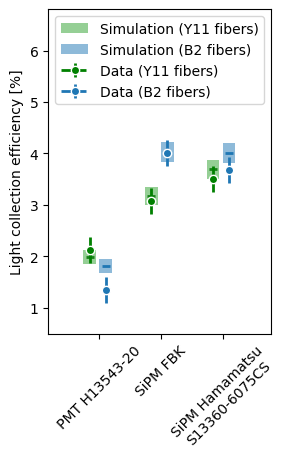

In [28]:
fig, ax = plt.subplots(1,1, figsize=(2.75,4.5), constrained_layout=True)

green_fibers = [eff_fibers_pmt, 
                eff_fibers_fbk_y11, 
                eff_fibers_hamamatsu]
blue_fibers = [eff_fibers_pmt_b2, 
               eff_fibers_fbk_b2, 
               eff_fibers_hamamatsu_b2]

for i in range(1,4):
    ax.errorbar(i-0.13, green_fibers[i-1], yerr=0.25,  ls="--", markeredgecolor='w', fmt='go', 
                label='Data (Y11 fibers)' if i == 1 else '')
    ax.errorbar(i+0.13, blue_fibers[i-1], yerr=0.25,  ls="--", fmt='o', ecolor='tab:blue', markerfacecolor='tab:blue', markeredgecolor='w',
                label='Data (B2 fibers)' if i == 1 else '')

ax.scatter(0.87, mc_eff*100, marker='_', c='darkgreen')
ax.fill_between([0.77,0.97], (mc_eff-mc_eff_err)*100, (mc_eff+mc_eff_err)*100, fc='tab:green', alpha=0.5, label='Simulation (Y11 fibers)')
ax.scatter(1.13, mc_eff_blue*100, marker='_', c='tab:blue')
ax.fill_between([1.03,1.23], (mc_eff_blue-mc_eff_blue_err)*100, (mc_eff_blue+mc_eff_blue_err)*100, fc='tab:blue', alpha=0.5, label='Simulation (B2 fibers)')

ax.scatter(1.87, mc_eff_fbk*100, marker='_', c='darkgreen')
ax.fill_between([1.77,1.97], (mc_eff_fbk-mc_eff_fbk_err)*100, (mc_eff_fbk+mc_eff_fbk_err)*100, fc='tab:green', alpha=0.5)
ax.scatter(2.13, mc_eff_fbk_blue*100, marker='_', c='tab:blue')
ax.fill_between([2.03,2.23], (mc_eff_fbk_blue-mc_eff_fbk_blue_err)*100, (mc_eff_fbk_blue+mc_eff_fbk_blue_err)*100, 
                fc='tab:blue', alpha=0.5)

ax.scatter(2.87, mc_eff_hamamatsu*100, marker='_', c='darkgreen')
ax.fill_between([2.77,2.97], (mc_eff_hamamatsu-mc_eff_hamamatsu_err)*100, (mc_eff_hamamatsu+mc_eff_hamamatsu_err)*100, fc='tab:green', alpha=0.5)
ax.scatter(3.13, mc_eff_hamamatsu_blue*100, marker='_', c='tab:blue')
ax.fill_between([3.03,3.23], (mc_eff_hamamatsu_blue-mc_eff_hamamatsu_blue_err)*100, (mc_eff_hamamatsu_blue+mc_eff_hamamatsu_blue_err)*100, 
                fc='tab:blue', alpha=0.5)


ax.set_xlim(0.2,3.8)
ax.set_xticks([1.025,2.025,3.025], ['PMT H13543-20', 'SiPM FBK', 'SiPM Hamamatsu\nS13360-6075CS'], rotation=45)
ax.set_ylabel("Light collection efficiency [%]")
ax.set_ylim(0.5,6.8)
ax.legend(loc=2)
fig.savefig("light_efficiency.pdf", transparent=True)